In [1]:
import torch
import skripsi_program
from skripsi_program import (
    SpectralSVR,
    to_complex_coeff,
    to_real_coeff,
    FourierBasis,
    LSSVR,
    StandardScaler,
    reduce_coeff,
    zero_coeff,
    # rmse,
    # mse,
    # r2_score,
    # r2_expected_score,
)
import numpy as np
from torchmetrics.functional import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    relative_squared_error,
    symmetric_mean_absolute_percentage_error
)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
generator = torch.Generator().manual_seed(42)
modes = [500]
prod_modes = int(np.prod(modes))
num_samples = 4001
k = FourierBasis.waveNumber(prod_modes)
u_coeff_clean = FourierBasis.generateCoeff(num_samples, prod_modes, generator=generator, random_func=torch.rand)
ut_coeff_clean = u_coeff_clean * 2j * torch.pi * k.T 
utt_coeff_clean = ut_coeff_clean * 2j * torch.pi * k.T # d2f/dt2
# u_coeff = u_coeff.reshape((-1, *modes))
# f_coeff = f_coeff.reshape((-1, *modes))
u_coeff_clean.shape

torch.Size([4001, 500])

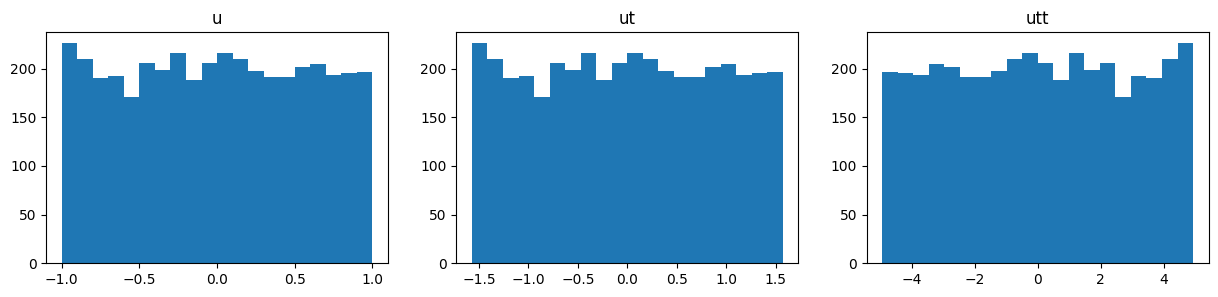

In [11]:
def visualize_dist_coeff(dim=0):
    fig, axs = plt.subplots(1, 3, figsize=[15,3])

    axs[0].hist(u_coeff_clean[:,dim].real, bins = 20)
    axs[0].set_title("u")
    axs[1].hist(ut_coeff_clean[:,dim].imag/8, bins = 20)
    axs[1].set_title("ut")
    axs[2].hist(utt_coeff_clean[:,dim].real/32, bins = 20)
    axs[2].set_title("utt")
    plt.show()
visualize_dist_coeff(2)

torch.Size([4001, 900])

tensor(0.4996)

tensor(0.1667)

tensor(15.5632)

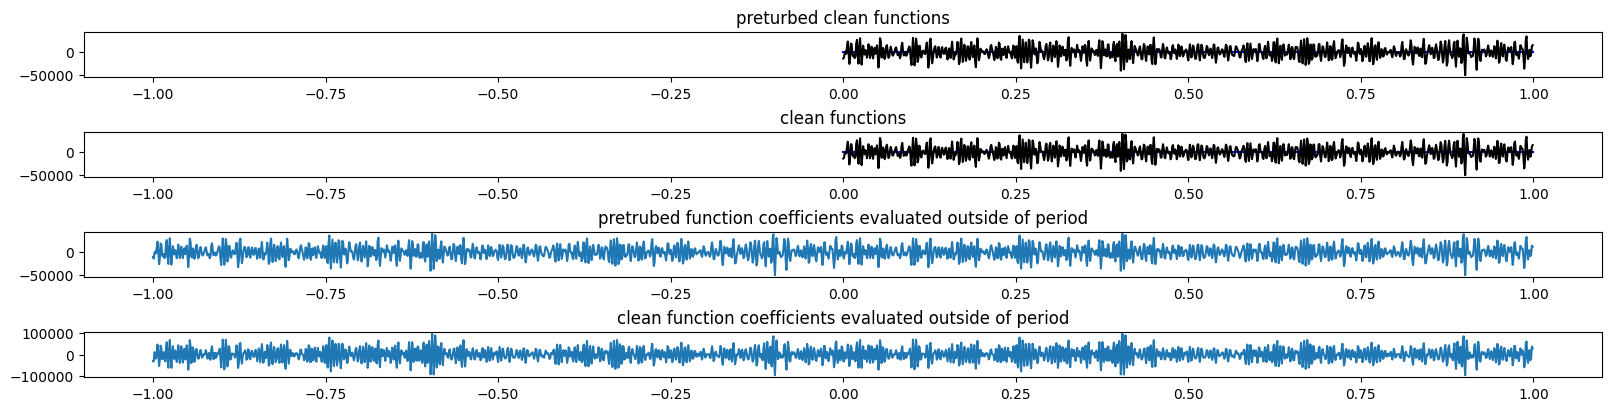

In [12]:
period = 1.0
periods = [period] * len(modes)
sample_freq = 900.0
sample_step = period / sample_freq
t = torch.arange(0, 1, sample_step)
tmp = [t for i in range(len(modes))]
tt = torch.meshgrid(tmp, indexing="ij")
tt_flat = [t.flatten() for t in tt]
points_tt = torch.concat([t.unsqueeze(-1) for t in tt_flat], 1)
u_basis = FourierBasis(u_coeff_clean, periods)
# ut_basis = FourierBasis(ut_coeff_clean, periods)
# utt_basis = FourierBasis(utt_coeff_clean, periods)
# points_tt.requires_grad_()
u_clean = u_basis.evaluate(points_tt).real
ut_clean = torch.gradient(u_clean, spacing=tt_flat, dim=1)[0]
# ut_clean = ut_basis.evaluate(points_tt).real
utt_clean = torch.gradient(ut_clean, spacing=tt_flat, dim=1)[0]

# points_tt.requires_grad_(False)
# utt_clean = utt_basis.evaluate(points_tt).real
u = u_clean + torch.randn_like(u_clean) * 0.05 * u_clean.std()
ut = ut_clean + torch.randn_like(ut_clean) * 0.05 * ut_clean.std()
utt = utt_clean + torch.randn_like(utt_clean) * 0.05 * utt_clean.std()
u_coeff = reduce_coeff(FourierBasis.transform(u), modes)
ut_coeff = reduce_coeff(FourierBasis.transform(ut), modes)
utt_coeff = reduce_coeff(FourierBasis.transform(utt), modes)
u_shape = u.shape


def signal_stats():
    # u_real, u_clean_real = to_real_coeff(u), to_real_coeff(u_clean)
    u_real, u_clean_real = to_real_coeff(u_coeff), to_real_coeff(u_coeff_clean)
    r2 = r2_score(u_real, u_clean_real)
    MSE = mean_squared_error(u_real, u_clean_real)
    display(u_shape)
    display(r2)
    display(MSE)
    display(20 * u_clean_real.max().log10() - 10 * MSE.pow(2).log10())


signal_stats()


def tmp_plot():
    points = torch.arange(-1, 1, sample_step)
    utt_eval = FourierBasis(utt_coeff[2, None], periods=periods).evaluate(
        points.view((-1, 1))
    )
    utt_clean_eval = FourierBasis(utt_coeff_clean[2, None], periods=periods).evaluate(
        points.view((-1, 1))
    )
    plt.figure(figsize=(16, 4), constrained_layout=True)
    ax1 = plt.subplot(411)
    plt.plot(t, u[2].real, color="b")
    plt.plot(t, utt[2].real, color="k")
    plt.title("preturbed clean functions")
    plt.subplot(412, sharex=ax1)
    plt.plot(t, u_clean[2].real, color="b")
    plt.plot(t, utt_clean[2].real, color="k")
    plt.title("clean functions")
    plt.subplot(413, sharex=ax1)
    plt.plot(points, utt_eval[0].real)
    plt.title("pretrubed function coefficients evaluated outside of period")
    plt.subplot(414, sharex=ax1)
    plt.plot(points, utt_clean_eval[0].real)
    plt.title("clean function coefficients evaluated outside of period")
    plt.show()


tmp_plot()

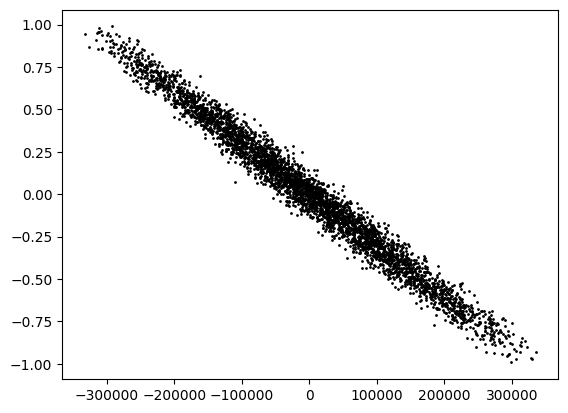

In [13]:
plt.plot(utt_coeff[:,98].real,u_coeff[:,98].real, 'ko', ms=1)
plt.show()

In [14]:
points_tt.requires_grad_(False)
u_clean = u_basis.evaluate(points_tt).real

# torch.gradient(u_clean, dim=0, spacing=sample_step)[0], u_clean

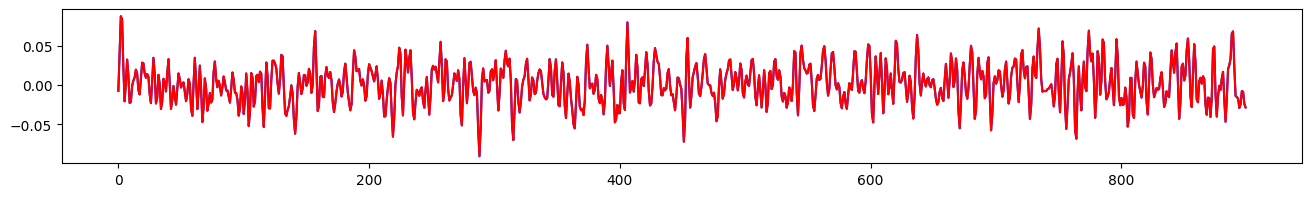

In [15]:
u_coeff_zeroed = zero_coeff(FourierBasis.transform(u), modes)
utt_coeff_zeroed = zero_coeff(FourierBasis.transform(utt), modes)
plt.figure(figsize=(16,2))
# plt.plot(u_clean.real[0], color="black")
plt.plot(FourierBasis(u_coeff,periods).evaluate(points_tt).real[0], color="blue")
plt.plot(FourierBasis(u_coeff_zeroed).evaluate(points_tt).real[0], color="red")
plt.show()

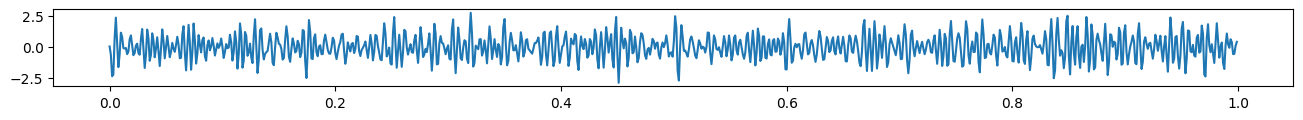

In [16]:
from torch.utils.data import TensorDataset, random_split

input_data = (utt, utt_coeff)
output_data = (u, u_coeff)
# data = (utt, utt_coeff, u, u_coeff_zeroed)
# (utt_scaled, utt_coeff_scaled, u_scaled, u_coeff_scaled) = data
input_scaler = StandardScaler().fit(input_data)
output_scaler = StandardScaler().fit(output_data)
# input_data_scaled = input_data
input_data_scaled = input_scaler.transform(input_data)
output_data_scaled = output_scaler.transform(output_data)
dataset = TensorDataset(*input_data_scaled, *output_data)
dataset_train, dataset_test = random_split(
    dataset, (0.8, 0.2), generator=torch.Generator().manual_seed(42)
)
# f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_train.shape, f_coeff_train.shape, u_coeff_train.shape
plt.figure(figsize=(16, 1))
plt.plot(points_tt[:], dataset[0][0])
plt.show()

In [28]:
f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_input_train = f_train
f_input_train = to_real_coeff(f_coeff_train)

f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_input_test = f_test
f_input_test = to_real_coeff(f_coeff_test)
model = SpectralSVR(
    FourierBasis(periods=periods),
    # C=1.227,
    C=1.00,
    # sigma=1.0,
    # sigma=f_input_train.var(0).median().multiply(f_input_train.shape[1]).pow(0.5),
    sigma=f_input_train.var(0).sum().pow(0.5) * 1.0,
    # sigma=70.0,
    kernel="linear",
    # kernel="rbf",
    batch_size_func=lambda dims:10000000
    # verbose="LSSVR",
)
# model.train(f_input_train, u_coeff_train * 900/200, list(u_coeff_zeroed.shape[1:]))
model.train(f_input_train, u_coeff_train, modes).test(f_input_test, u_coeff_test)

transform u_coeff to real


{'mse': 0.020359046757221222,
 'rmse': 0.14268513023853302,
 'mae': 0.06458031386137009,
 'r2': 0.8792747259140015,
 'r2_abs': 0.8792747259140015,
 'smape': 0.3550914525985718,
 'rse': 0.12072531133890152,
 'rrse': 0.19595474004745483,
 'pred_nan_sum': 0}

In [29]:
dataset[:][1].shape

torch.Size([4001, 500])

In [30]:
0.7664933204650879, 10001, 500
0.8296816349029541, 10001, 400
0.8629440069198608, 10001, 300
0.8817722201347351, 10001, 200
0.9040015339851379, 10001, 100
0.6855265498161316, 11001, 500
0.8038439750671387, 11001, 400
0.860628068447113 , 11001, 300
0.883353054523468 , 11001, 200
0.9047563672065735, 11001, 100
0.5994590520858765, 12001, 500

(0.5994590520858765, 12001, 500)

In [31]:
u_pred = model.forward(f_input_test, points_tt)
u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test)) 
# u_coeff_pred = u_coeff_pred * u_coeff_test.std() / u_coeff_pred.std()
# u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test))
u_pred_basis = FourierBasis(u_coeff_pred, periods)
u_basis_pred = u_pred_basis.evaluate(points_tt)
# u_pred = lssvr.predict(points_tt).T
u_pred.shape, model

(torch.Size([800, 900]),
 <skripsi_program.model.SpectralSVR.SpectralSVR at 0x2084e4abeb0>)

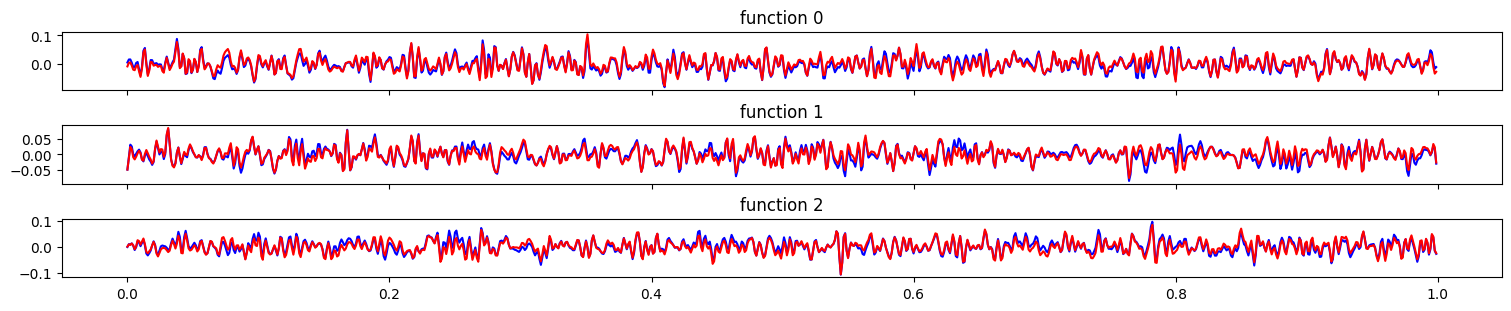

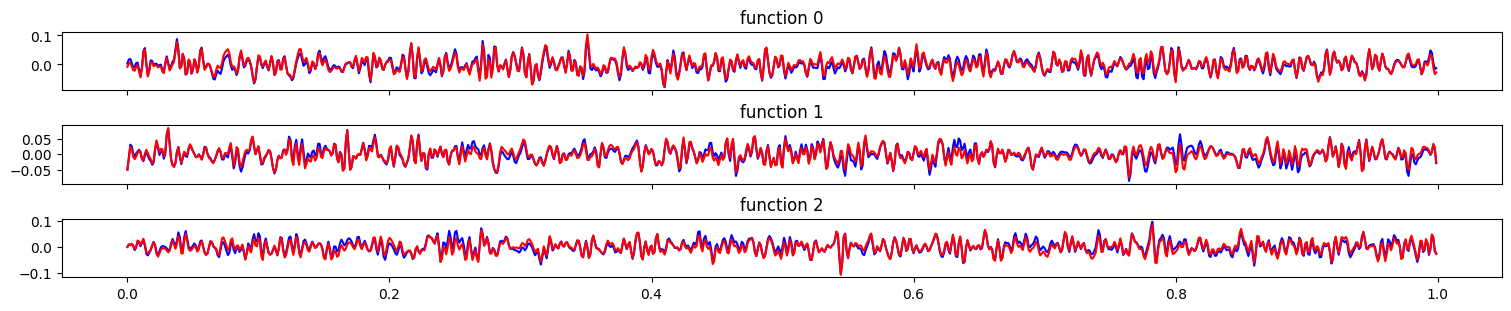

In [32]:
# do this because forward in SpectralSVR isn't scaling invariant
u_test_eval = FourierBasis(u_coeff_test).evaluate(points_tt).real
# u_coeff_clean_scaled = u_coeff_clean
# u_coeff_clean_scaled = scaler.get_subset_scaler([-1]).transform((u_coeff_clean,))[0][dataset_test.indices]
u_coeff_clean_eval = FourierBasis(u_coeff_clean[dataset_test.indices]).evaluate(points_tt).real


def plot_funcs(u_pred: torch.Tensor, u: torch.Tensor, n=6):
    # line_styles = ["solid", "dotted", "dashed", "dashdot"]
    fig, axs = plt.subplots(n, 1, figsize=[15, n], constrained_layout=True, sharex=True)
    for i in range(n):
        # axs[i%2, i//2].scatter(points_sampled[:,1], u_sampled[i, :])
        # axs[i%2, i//2].plot(t, u_basis_pred[i].real, color="black")
        # axs[i].plot(t, u_test[i].real, color="blue")
        axs[i].plot(t, u[i].real, color="blue")
        axs[i].plot(t, u_pred[i].real, color="red")
        axs[i].set_title(f"function {i}")

    plt.show()


# plot_funcs(u_pred.real, u_test_eval.real, 2)
# plot_funcs(u_pred, u_coeff_clean_eval, 2)
plot_funcs(u_basis_pred.real, u_test_eval.real, 3)
plot_funcs(u_basis_pred.real, u_coeff_clean_eval, 3)

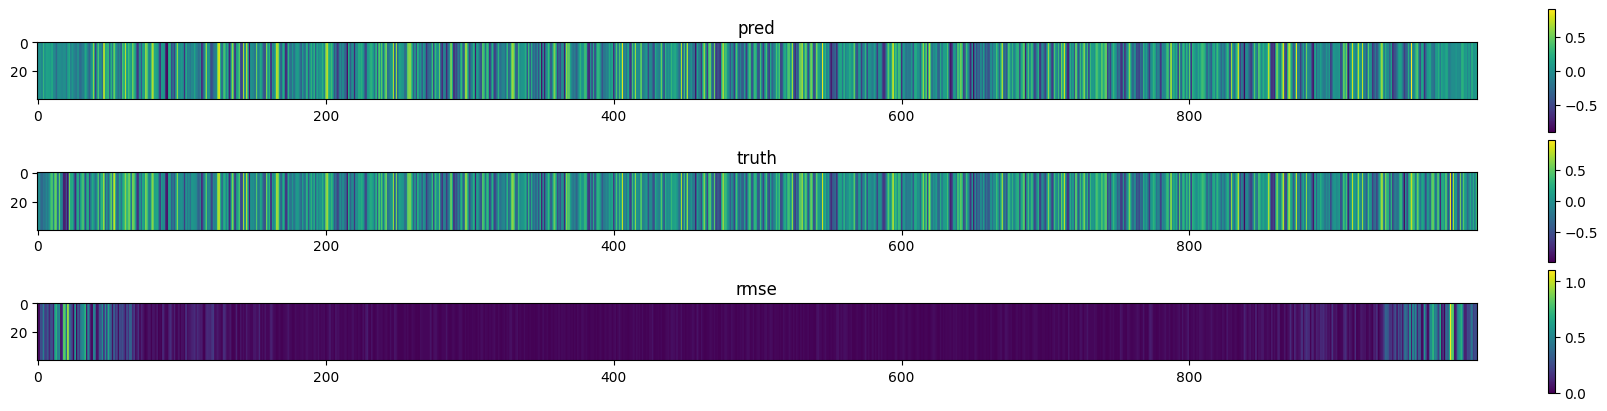

In [33]:
def plot_coeffs(coeff_pred: torch.Tensor, coeff: torch.Tensor, n=0):
    # k = FourierBasis.waveNumber(coeff_pred.shape[1]).T[0].numpy() * 1.
    # print(k.shape)
    # print(coeff_pred.shape)
    height = coeff_pred.shape[1]//25
    plt.figure(figsize=(16, 4), constrained_layout=True)
    plt.subplot(311)
    plt.imshow(coeff_pred[n].view((1, -1)).expand((height,-1)))
    plt.title("pred")
    plt.colorbar()
    plt.subplot(312)
    plt.imshow(coeff[n].view((1, -1)).expand((height,-1)))
    plt.title("truth")
    plt.colorbar()
    plt.subplot(313)
    plt.imshow(
        mean_squared_error(
            coeff_pred[n, None],
            coeff[n, None],
            squared=False,
            num_outputs=coeff.shape[1],
        ).view((1, -1)).expand((height,-1))
    )
    plt.title("rmse")
    plt.colorbar()

    plt.show()


plot_coeffs(to_real_coeff(u_coeff_pred), to_real_coeff(u_coeff_test), 1)

In [34]:
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[0:10]
u_test_basis = FourierBasis(u_coeff_test, periods=periods)
u_inv = u_test_basis.evaluate(points_tt).real
inverse_pred = model.inverse(u_inv, points_tt, epochs=5000, lr=1e-3, loss_fn=mean_squared_error, gain=1e-4).detach()


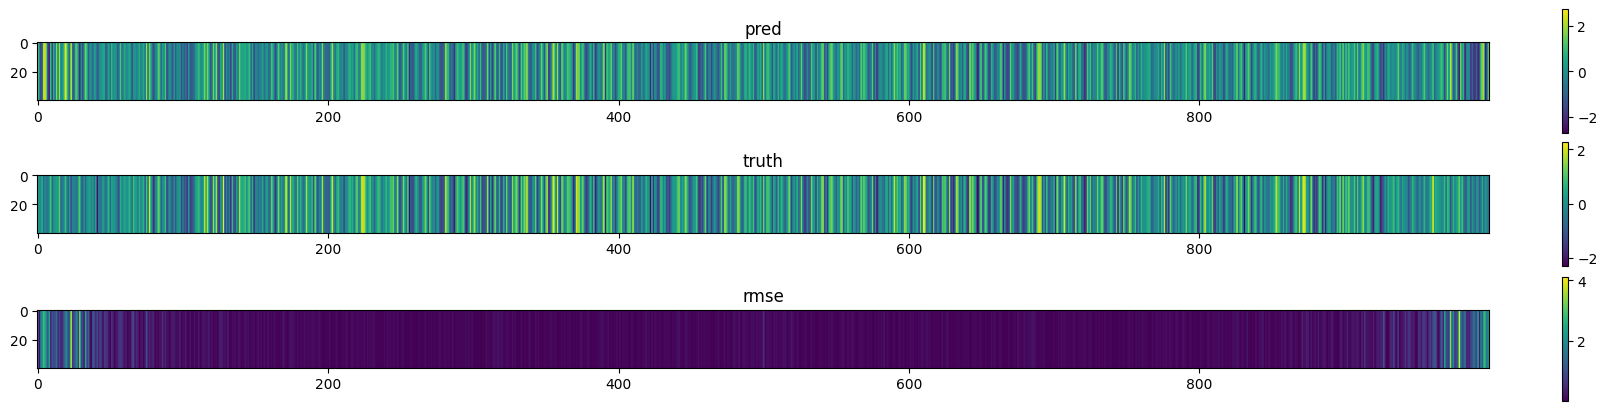

In [35]:
f_truth = to_real_coeff(f_coeff_test)
# f_truth = FourierBasis(periods=periods).evaluate(points_tt, f_coeff_test, periods,modes=modes).real
# plot_funcs(inverse_pred, f_truth, n=10)
plot_coeffs(inverse_pred, f_truth)

In [25]:
preds = inverse_pred.real
targets = f_truth.real
(
    mean_squared_error(preds, targets),
    r2_score(preds, targets),
    mean_absolute_error(preds, targets),
    symmetric_mean_absolute_percentage_error(preds, targets),
    f_truth.shape,
)


(tensor(0.1940),
 tensor(0.7643),
 tensor(0.2491),
 tensor(0.5232),
 torch.Size([10, 1000]))

In [26]:
# tmp_test = torch.randn((2000, 2000))
# tmp_unscaled = LSSVR(kernel="tri", sigma=1.0)
# tmp_prod = 1 - tmp_unscaled._batched_K(tmp_test, tmp_test)
# display(tmp_prod)
# tmp_sigma = tmp_prod.max()
# tmp_model = LSSVR(kernel="rbf", sigma =tmp_test.var(0).sum()**.5)
# tmp_gram = tmp_model._batched_K(tmp_test,tmp_test)
# display(tmp_gram)
# def is_psd(mat):
#     return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())
# #Test:
# display(is_psd(tmp_gram), is_psd(tmp_prod))
# model.svr.K
# display((tmp_gram == tmp_gram.T).all())
# tmp_eig = torch.linalg.eigvals(tmp_gram).real
# display(tmp_eig[(tmp_eig>=0 )== False], tmp_eig.shape)